In [ ]:
#| echo: false

# This cell will not be rendered but is to hide warnings and limit the rows shown

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('statsforecast').setLevel(logging.ERROR)

import pandas as pd
pd.set_option('display.max_rows', 6)

# AutoCES Model

> Step-by-step guide on using the `AutoCES Model` with `Statsforecast`.

The objective of the following article is to obtain a step-by-step guide on building the CES model using `AutoCES` with `Statsforecast`.

During this walkthrough, we will become familiar with the main `StatsForecast` class and some relevant methods such as `StatsForecast.plot`, `StatsForecast.forecast` and `StatsForecast.cross_validation` in other.

The text in this article is largely taken from:
1. [Ivan Svetunkov, Nikolaos Kourentzes, John Keith Ord, "Complex exponential smoothing"](https://onlinelibrary.wiley.com/doi/full/10.1002/nav.22074)
2. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).



## Table of Contents

* [Introduction](#introduction)
* [Complex Exponential Smoothing](#model)
* [Loading libraries and data](#loading)
* [Explore data with the plot method](#plotting)
* [Split the data into training and testing](#splitting)
* [Implementation of AutoCES with StatsForecast](#implementation)
* [Cross-validation](#cross_validate)
* [Model evaluation](#evaluate)
* [References](#references)

## Introduction <a class="anchor" id="introduction"></a>

Exponential smoothing has been one of the most popular forecasting methods used to support various decisions in organizations, in activities such as inventory management, scheduling, revenue management, and other areas. Although its relative simplicity and transparency have made it very attractive for research and practice, identifying the underlying trend remains challenging with significant impact on the resulting accuracy. This has resulted in the development of various modifications of trend models, introducing a model selection problem. With the aim of addressing this problem, we propose the complex exponential smoothing (CES), based on the theory of functions of complex variables. The basic CES approach involves only two parameters and does not require a model selection procedure. Despite these simplifications, CES proves to be competitive with, or even superior to existing methods. We show that CES has several advantages over conventional exponential smoothing models: it can model and forecast both stationary and non-stationary processes, and CES can capture both level and trend cases, as defined in the conventional exponential smoothing classification. CES is evaluated on several forecasting competition datasets, demonstrating better performance than established benchmarks. We conclude that CES has desirable features for time series modeling and opens new promising avenues for research.

# Complex Exponential Smoothing <a class="anchor" id="model"></a>

### Method and model

Using the complex valued representation of time series, we propose the CES in analogy to the conventional exponential smoothing methods. Consider the simple exponential smoothing method:

$$
\begin{equation}
    {\hat{y}}_t=\alpha {y}_{t-1}+\left(1-\alpha \right){\hat{y}}_{t-1} \tag{1}
\end{equation}
$$

where $\alpha$ is the smoothing parameter and ${\hat{y}}_t$ is the estimated value of series. The same method can be represented as a weighted average of previous actual observations if we substitute ${\hat{y}}_{t-1}$ by the formula (1) with an index  instead of  (Brown, 1956):

$$
\begin{equation}
    {\hat{y}}_t=\alpha \sum \limits_{j=1}^{t-1}{\left(1-\alpha \right)}^{j-1}{y}_{t-j} \tag{2}
\end{equation}
$$

The idea of this representation is to demonstrate how the weights $\alpha {\left(1-\alpha \right)}^{j-1}$ are distributed over time in our sample. If the smoothing parameter $\alpha \in \left(0,1\right)$ then the weights decline exponentially with the increase of . If it lies in the so called “admissible bounds” (Brenner et al., 1968), that is $\alpha \in \left(0,2\right)$ then the weights decline in oscillating manner. Both traditional and admissible bounds have been used efficiently in practice and in academic literature (for application of the latter see for example Gardner & Diaz-Saiz, 2008; Snyder et al., 2017). However, in real life the distribution of weights can be more complex, with harmonic rather than exponential decline, meaning that some of the past observation might have more importance than the recent ones. In order to implement such distribution of weights, we build upon (2) and introduce complex dynamic interactions by substituting the real variables with the complex ones in (2). First, we substitute ${y}_{t-j}$ by the complex variable ${y}_{t-j}+{ie}_{t-j}$, where ${e}_t$ is the error term of the model and $i$ is the imaginary unit (which satisfies the equation ${i}^2=-1$). The idea behind this is to have the impact of both actual values and the error on each observation in the past on the final forecast. Second, we substitute $\alpha$ with a complex variable ${\alpha}_0+i{\alpha}_1$ and  1 by $1+i$ to introduce the harmonically declining weights. Depending on the values of the complex smoothing parameter, the weights distribution will exhibit a variety of trajectories over time, including exponential, oscillating, and harmonic. Finally, the result of multiplication of two complex numbers will be another complex number, so we substitute ${\hat{y}}_{t-j}$ with ${\hat{y}}_{t-j}+i{\hat{e}}_{t-j}$, where ${\hat{e}}_{t-j}$ is the proxy for the error term. The CES obtained as a result of this can be written as:

$$
\begin{equation}
    {\hat{y}}_t+i{\hat{e}}_t=\left({\alpha}_0+i{\alpha}_1\right)\sum \limits_{j=1}^{t-1}{\left(1+i-\left({\alpha}_0+i{\alpha}_1\right)\right)}^{j-1}\left({y}_{t-j}+{ie}_{t-j}\right) \tag{3}
\end{equation}
$$

 Having arrived to the model with harmonically distributed weights, we can now move to the shorter form by substituting

$${\displaystyle \begin{array}{cc}& {\hat{y}}_{t-1}+i{\hat{e}}_{t-1}\\ {}& \kern1em =\left({\alpha}_0+i{\alpha}_1\right)\sum \limits_{j=2}^{t-1}{\left(1+i-\left({\alpha}_0+i{\alpha}_1\right)\right)}^{j-1}\left({y}_{t-j}+{ie}_{t-j}\right)\end{array}}$$

 in (3) to get:

$$
\begin{equation}
    {\displaystyle \begin{array}{cc}{\hat{y}}_t+i{\hat{e}}_t& =\left({\alpha}_0+i{\alpha}_1\right)\left({y}_{t-1}+{ie}_{t-1}\right)\\ {}& \kern1em +\left(1-{\alpha}_0+i-i{\alpha}_1\right)\left({\hat{y}}_{t-1}+i{\hat{e}}_{t-1}\right).\end{array}} \tag 4
\end{equation}
$$

Note that ${\hat{e}}_t$ is not interesting for the time series analysis and forecasting purposes, but is used as a vessel containing the information about the previous errors of the method. Having the complex variables instead of the real ones in (4), allows taking the exponentially weighted values of both actuals and the forecast errors. By changing the value of ${\alpha}_0+i{\alpha}_1$ , we can regulate what proportions of the actual and the forecast error should be carried out to the future in order to produce forecasts.

Representing the complex-valued function as a system of two real-valued functions leads to:

$$
\begin{equation}
    {\displaystyle \begin{array}{ll}& {\hat{y}}_t=\left({\alpha}_0{y}_{t-1}+\left(1-{\alpha}_0\right){\hat{y}}_{t-1}\right)-\left({\alpha}_1{e}_{t-1}+\left(1-{\alpha}_1\right){\hat{e}}_{t-1}\right)\\ {}& {\hat{e}}_t=\left({\alpha}_1{y}_{t-1}+\left(1-{\alpha}_1\right){\hat{y}}_{t-1}\right)+\left({\alpha}_0{e}_{t-1}+\left(1-{\alpha}_0\right){\hat{e}}_{t-1}\right).\end{array}} \tag 5
\end{equation}
$$

CES introduces an interaction between the real and imaginary parts, and the equations in (6) are connected via the previous values of each other, causing interactions over time, defined by complex smoothing parameter value.

But the method itself is restrictive and does not allow easily producing prediction intervals and deriving the likelihood function. It is also important to understand what sort of statistical model underlies CES. This model can be written in the following state space form:

$$
\begin{equation}
    {\displaystyle \begin{array}{ll}& {y}_t={l}_{t-1}+{\epsilon}_t\\ {}& {l}_t={l}_{t-1}-\left(1-{\alpha}_1\right){c}_{t-1}+\left({\alpha}_0-{\alpha}_1\right){\epsilon}_t\\ {}& {c}_t={l}_{t-1}+\left(1-{\alpha}_0\right){c}_{t-1}+\left({\alpha}_0+{\alpha}_1\right){\epsilon}_t,\end{array}} \tag 6
\end{equation}
$$

where ${\epsilon}_t$ is the white noise error term, ${l}_t$ is the level component and ${c}_t$ is the nonlinear trend component at observation . Observe that dependencies in time series have an interactive structure and no explicit trend component is present in the time series as this model does not need to artificially break the series into level and trend, as ETS does. Although we call the ${c}_t$ component as “nonlinear trend,” it does not correspond to the conventional trend component, because it contains the information of both previous ${c}_{t-1}$ and the level ${l}_{t-1}$. Also, note that we use ${\epsilon}_t$ instead of ${e}_t$ in (6), which means that the CES has (6) as an underlying statistical model only when there is no misspecification error. In the case of the estimation of this model, the ${\epsilon}_t$ will be substituted by ${e}_t$, which will then lead us to the original formulation (4).

This idea allows rewriting (6) in a shorter more generic way, resembling the general single source of error (SSOE) state space framework:

$$
\begin{equation}
    {\displaystyle \begin{array}{ll}& {y}_t={\mathbf{w}}^{\prime }{\mathbf{v}}_{t-1}+{\epsilon}_t\\ {}& {\mathbf{v}}_t={\mathbf{Fv}}_{t-1}+\mathbf{g}{\epsilon}_t,\end{array}} \tag 7
\end{equation}
$$

where 
$${\mathbf{v}}_t=\left(\begin{array}{c}{l}_t\\ {}{c}_t\end{array}\right)$$ is the state vector

$$\mathbf{F}=\left(\begin{array}{cc}1& -\left(1-{\alpha}_1\right)\\ {}1& 1-{\alpha}_0\end{array}\right)$$ is the transition matrix

$$\mathbf{g}=\left(\begin{array}{c}{\alpha}_0-{\alpha}_1\\ {}{\alpha}_0+{\alpha}_1\end{array}\right)$$ is the persistence vector and 

$$\mathbf{w}=\left(\begin{array}{c}1\\ {}0\end{array}\right)$$ is the measurement vector.

The state space form (7) permits extending CES in a similar ways to ETS to include additional states for seasonality or exogenous variables. The main difference between model (7) and the conventional ETS is that the transition matrix in (7) includes smoothing parameters which is not a standard feature of ETS models. Furthermore persistence vector includes the interaction of complex smoothing parameters, rather than smoothing parameters themselves.

The error term in (6) is additive, so the likelihood function for CES is trivial and is similar to the one in the additive exponential smoothing models (Hyndman et al., 2008, p. 68):

$$
\begin{equation}
    \mathrm{\mathcal{L}}\left(\mathbf{g},{\mathbf{v}}_0,{\sigma}^2\mid \mathbf{Y}\right)={\left(\frac{1}{\sigma \sqrt{2\pi }}\right)}^T\exp \left(-\frac{1}{2}\sum \limits_{t=1}^T{\left(\frac{\epsilon_t}{\sigma}\right)}^2\right), \tag 8
\end{equation}
$$

where ${\mathbf{v}}_0$ is the vector of initial states, ${\sigma}^2$ is the variance of the error term and $\mathbf{Y}$ is the vector of all the in-sample observations.

### Stationarity and stability conditions for CES

In order to understand the properties of CES, we need to study its stationarity and stability conditions. The former holds for general exponential smoothing in the state space form (8) when all the eigenvalues of  lie inside the unit circle (Hyndman et al., 2008, p. 38). CES can be either stationary or not, depending on the complex smoothing parameter value, in contrast to ETS models that are always non-stationary. Calculating eigenvalues of  for CES gives the following roots:

$$
\begin{equation}
    \lambda =\frac{2-{\alpha}_0\pm \sqrt{\alpha_0^2+4{\alpha}_1-4}}{2}. \tag 9
\end{equation}    
$$

If the absolute values of both roots are less than 1 then the estimated CES is stationary.

When ${\alpha}_1>1$ one of the eigenvalues will always be greater than one. In this case both eigenvalues will be real numbers and CES produces a non-stationary trajectory. When ${\alpha}_1=1$ CES becomes equivalent to ETS(A,N,N). Finally, the model becomes stationary when:

$$
\begin{equation}
    \left\{\begin{array}{l}{\alpha}_1<5-2{\alpha}_0\\ {}{\alpha}_1<1\\ {}{\alpha}_1>1-{\alpha}_0\end{array}\right.  \tag {10}
\end{equation}
$$

Note that we are not restricting CES with the conditions (10), we merely show, how the model will behave depending on the value of the complex smoothing parameter. This property of CES means that it is able to model either stationary or non-stationary processes, without the need to switch between them. The property of CES for each separate time series depends on the value of the smoothing parameters.

The other important property that arises from (7) is the stability condition for CES. With $\epsilon_t={y}_t-{l}_{t-1}$ the following is obtained:

$$
\begin{equation}
    {\displaystyle \begin{array}{ll}{y}_t& ={l}_{t-1}+{\epsilon}_t\\ {}\left(\begin{array}{c}{l}_t\\ {}{c}_t\end{array}\right)& =\left(\begin{array}{cc}1-{\alpha}_0+{\alpha}_1& -\left(1-{\alpha}_1\right)\\ {}1-{\alpha}_0-{\alpha}_1& 1-{\alpha}_0\end{array}\right)\left(\begin{array}{c}{l}_{t-1}\\ {}{c}_{t-1}\end{array}\right)\\ {}& \kern1em +\left(\begin{array}{c}{\alpha}_0-{\alpha}_1\\ {}{\alpha}_1+{\alpha}_0\end{array}\right){y}_t.\end{array}} \tag {11}
\end{equation}
$$

The matrix $$\mathbf{D}=\left(\begin{array}{cc}1-{\alpha}_0+{\alpha}_1& -\left(1-{\alpha}_1\right)\\ {}1-{\alpha}_0-{\alpha}_1& 1-{\alpha}_0\end{array}\right)$$ is called the discount matrix and can be written in the general form:

$$
\begin{equation}
    \mathbf{D}=\mathbf{F}-\mathbf{g}{\mathbf{w}}^{\prime }. \tag {12}
\end{equation}    
$$

The model is said to be stable if all the eigenvalues of (12) lie inside the unit circle. This is more important condition than the stationarity for the model, because it ensures that the complex weights decline over time and that the older observations have smaller weights than the new ones, which is one of the main features of the conventional ETS models. The eigenvalues are given by the following formula:

$$
\begin{equation}
    \lambda =\frac{2-2{\alpha}_0+{\alpha}_1\pm \sqrt{8{\alpha}_1+4{\alpha}_0-4{\alpha}_0{\alpha}_1-4-3{\alpha}_1^2}}{2}. \tag {13}
\end{equation}
$$

CES will be stable when the following system of inequalities is satisfied:

$$
\begin{equation}
    \left\{\begin{array}{l}{\left({\alpha}_0-2.5\right)}^2+{\alpha}_1^2>1.25\\ {}{\left({\alpha}_0-0.5\right)}^2+{\left({\alpha}_1-1\right)}^2>0.25\\ {}{\left({\alpha}_0-1.5\right)}^2+{\left({\alpha}_1-0.5\right)}^2<1.5\end{array}.\right. \tag {14}
\end{equation}
$$

Both the stationarity and stability regions are shown in [Figure 1](https://onlinelibrary.wiley.com/cms/asset/2a1bdd28-bbba-4ec3-aa4a-fbcf3823a209/nav22074-fig-0001-m.jpg). The stationarity region (10) corresponds to the triangle. All the combinations of smoothing parameters lying below the curve in the triangle will produce the stationary harmonic trajectories, while the rest lead to the exponential trajectories. The stability condition (14) corresponds to the dark region. The stability region intersects the stationarity region, but in general stable CES can produce both stationary and non-stationary forecasts

### Conditional mean and variance of CES

The conditional mean of CES for $h$ steps ahead with known ${l}_t$ and ${c}_t$ can be calculated using the state space model (6):

$$
\begin{equation}
    \mathrm{E}\left({y}_{t+h}\mid {\mathbf{v}}_t\right)={\mathbf{w}}^{\prime }{\mathbf{F}}^{h-1}{\mathbf{v}}_t, \tag {15}
\end{equation}    
$$

where 

$$\mathrm{E}\left({y}_{t+h}\mid {\mathbf{v}}_t\right)={\hat{y}}_{t+h}$$

while $\mathbf{F}$ and $\mathbf{w}$ re the matrices from (7).

The forecasting trajectories of (15) will differ depending on the values of ${l}_t, {c}_t$, and the complex smoothing parameter. The analysis of stationarity condition shows that there are several types of forecasting trajectories of CES depending on the particular value of the complex smoothing parameter:

1. When ${\alpha}_1=1$ all the values of forecast will be equal to the last obtained forecast, which corresponds to a flat line. This trajectory is shown in [Figure 2A](https://onlinelibrary.wiley.com/cms/asset/16feeb7e-adf2-48f6-9df9-cab3e34b6e67/nav22074-fig-0002-m.jpg).
2. When ${\alpha}_1>1$ the model produces trajectory with exponential growth which is shown in [Figure 2B](https://onlinelibrary.wiley.com/cms/asset/16feeb7e-adf2-48f6-9df9-cab3e34b6e67/nav22074-fig-0002-m.jpg).
3. When $\frac{4-{\alpha}_0^2}{4}<{\alpha}_1<1$ trajectory becomes stationary and CES produces exponential decline shown in [Figure 2C](https://onlinelibrary.wiley.com/cms/asset/16feeb7e-adf2-48f6-9df9-cab3e34b6e67/nav22074-fig-0002-m.jpg).
4. When $1-{\alpha}_0<{\alpha}_1<\frac{4-{\alpha}_0^2}{4}$ trajectory becomes harmonic and will converge to zero [Figure 2D](https://onlinelibrary.wiley.com/cms/asset/16feeb7e-adf2-48f6-9df9-cab3e34b6e67/nav22074-fig-0002-m.jpg).
5. Finally, when $0<{\alpha}_1<1-{\alpha}_0$ the diverging harmonic trajectory is produced, the model becomes non-stationary. This trajectory is of no use in forecasting, that is why we do not show it on graphs.

Using (7) the conditional variance of CES for $h$ steps ahead with known ${l}_t$ and ${c}_t$ can be calculated similarly to the pure additive ETS models (Hyndman et al., 2008, p. 96).

## Loading libraries and data <a class="anchor" id="loading"></a>

:::{.callout-tip}
Statsforecast will be needed. To install, see [instructions](../getting-started/0_Installation../getting-started/0_Installation).
:::

Next, we import plotting libraries and configure the plotting style.

In [ ]:
import pandas as pd

import scipy.stats as stats

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (18,7)

### Read Data

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/Naren8520/Serie-de-tiempo-con-Machine-Learning/main/Data/Esperanza_vida.csv", usecols=[1,2])
df.head()

,year,value
0,1960-01-01,69.123902
1,1961-01-01,69.760244
2,1962-01-01,69.149756
3,1963-01-01,69.248049
4,1964-01-01,70.311707


The input to StatsForecast is always a data frame in long format with three columns: unique_id, ds and y:

* The `unique_id` (string, int or category) represents an identifier for the series.

* The `ds` (datestamp) column should be of a format expected by Pandas, ideally YYYY-MM-DD for a date or YYYY-MM-DD HH:MM:SS for a timestamp.

* The `y` (numeric) represents the measurement we wish to forecast.

In [ ]:
df["unique_id"]="1"
df.columns=["ds", "y", "unique_id"]
df.head()

,ds,y,unique_id
0,1960-01-01,69.123902,1
1,1961-01-01,69.760244,1
2,1962-01-01,69.149756,1
3,1963-01-01,69.248049,1
4,1964-01-01,70.311707,1


Now, let's now check the last few rows of our time series using the `.tail()` function.

In [ ]:
print(df.dtypes)

ds            object
y            float64
unique_id     object
dtype: object


We need to convert the `ds` from `object` type to datetime.

In [ ]:
df["ds"] = pd.to_datetime(df["ds"])

## Explore data with the plot method <a class="anchor" id="plotting"></a>

Plot some series using the plot method from the StatsForecast class. This method prints a random series from the dataset and is useful for basic EDA.

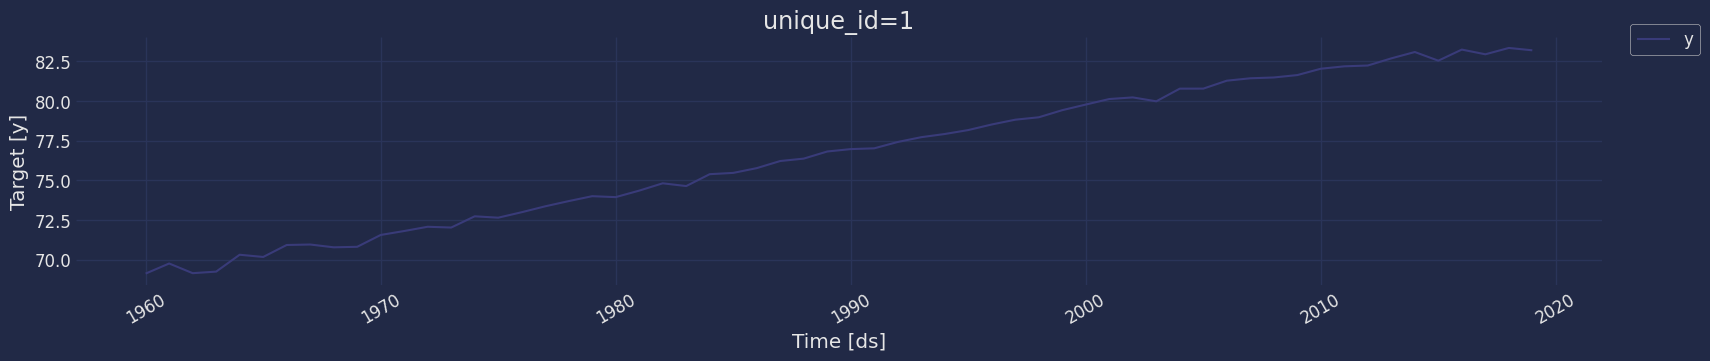

In [ ]:
from statsforecast import StatsForecast

StatsForecast.plot(df)

### Autocorrelation plots

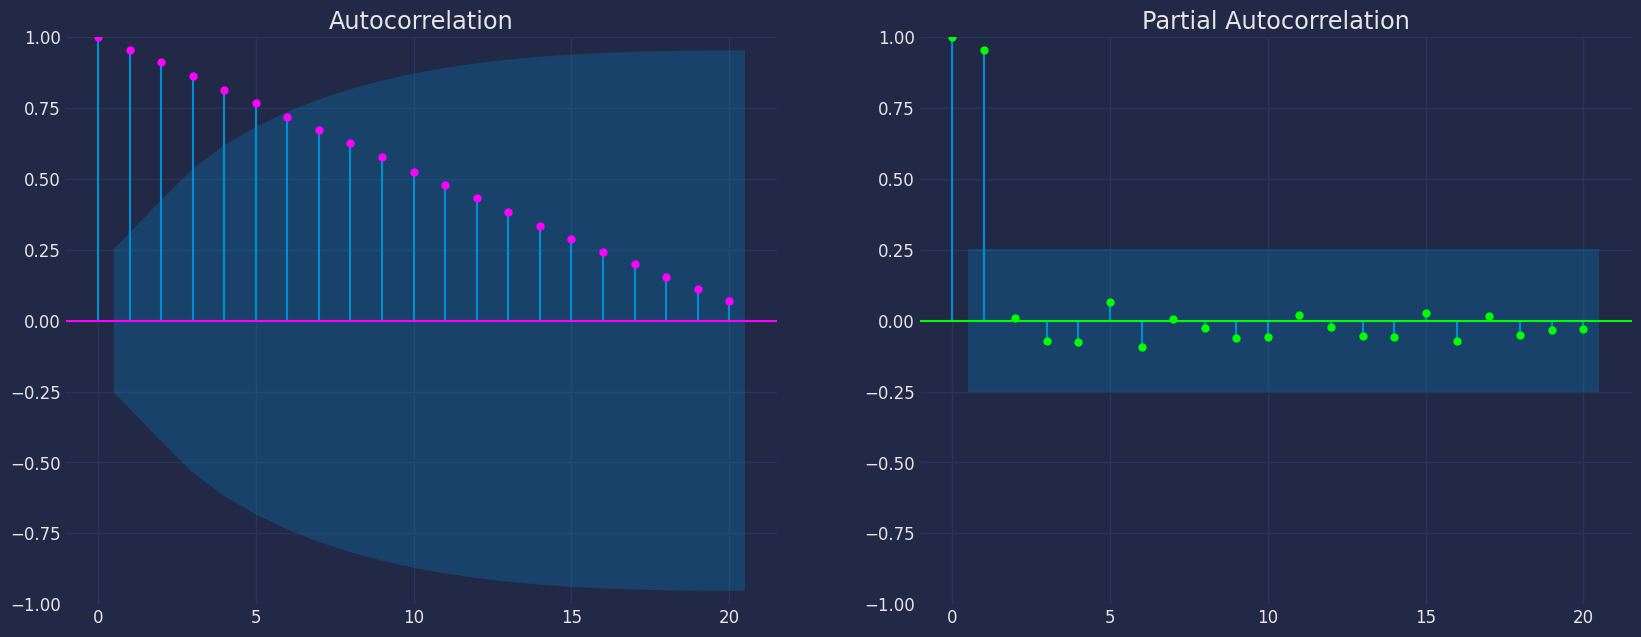

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2)

plot_acf(df["y"],  lags=20, ax=axs[0],color="fuchsia")
axs[0].set_title("Autocorrelation");

# Grafico
plot_pacf(df["y"],  lags=20, ax=axs[1],color="lime")
axs[1].set_title('Partial Autocorrelation')

#plt.savefig("Gráfico de Densidad y qq")
plt.show();

### Decomposition of the time series

How to decompose a time series and why?

In time series analysis to forecast new values, it is very important to know past data. More formally, we can say that it is very important to know the patterns that values follow over time. There can be many reasons that cause our forecast values to fall in the wrong direction. Basically, a time series consists of four components. The variation of those components causes the change in the pattern of the time series. These components are:

* **Level:** This is the primary value that averages over time.
* **Trend:** The trend is the value that causes increasing or decreasing patterns in a time series.
* **Seasonality:** This is a cyclical event that occurs in a time series for a short time and causes short-term increasing or decreasing patterns in a time series.
* **Residual/Noise:** These are the random variations in the time series.

Combining these components over time leads to the formation of a time series. Most time series consist of level and noise/residual and trend or seasonality are optional values.

If seasonality and trend are part of the time series, then there will be effects on the forecast value. As the pattern of the forecasted time series may be different from the previous time series.

The combination of the components in time series can be of two types:
* Additive
* Multiplicative

### Additive time series

If the components of the time series are added to make the time series. Then the time series is called the additive time series. By visualization, we can say that the time series is additive if the increasing or decreasing pattern of the time series is similar throughout the series. The mathematical function of any additive time series can be represented by:
$$y(t) = level + Trend + seasonality + noise$$

### Multiplicative time series

If the components of the time series are multiplicative together, then the time series is called a multiplicative time series. For visualization, if the time series is having exponential growth or decline with time, then the time series can be considered as the multiplicative time series. The mathematical function of the multiplicative time series can be represented as.

$$y(t) = Level * Trend * seasonality * Noise$$

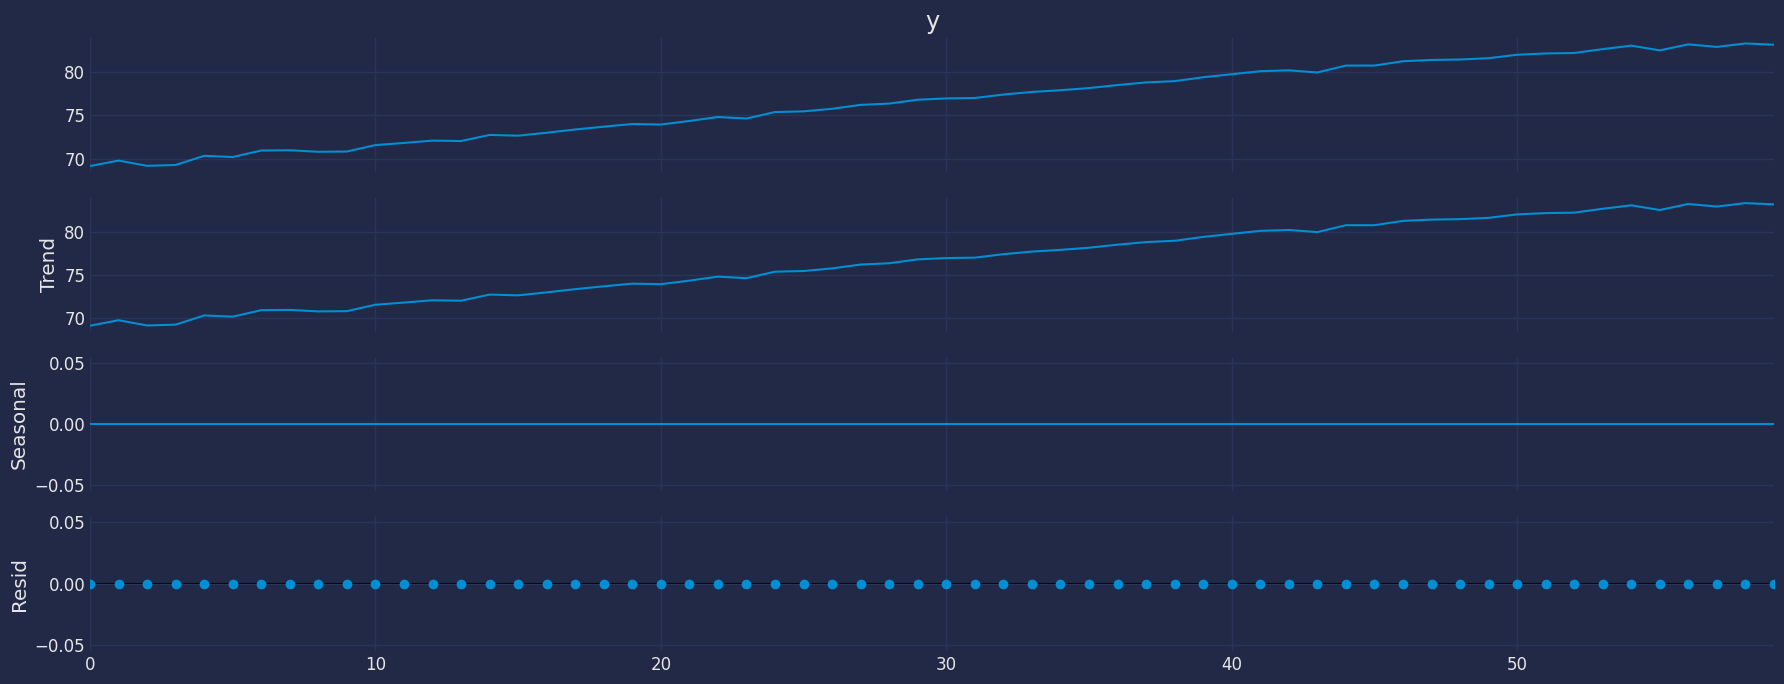

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
a = seasonal_decompose(df["y"], model = "add", period=1)
a.plot();

## Split the data into training and testing<a class="anchor" id="splitting"></a>

Let's divide our data into sets

1. Data to train our model.
2. Data to test our model.

For the test data we will use the last 12 months to test and evaluate the performance of our model.

In [ ]:
train = df[df.ds<='2013-01-01']
test = df[df.ds>'2013-01-01']

In [ ]:
train.shape, test.shape

((54, 3), (6, 3))

Now let's plot the training data and the test data.

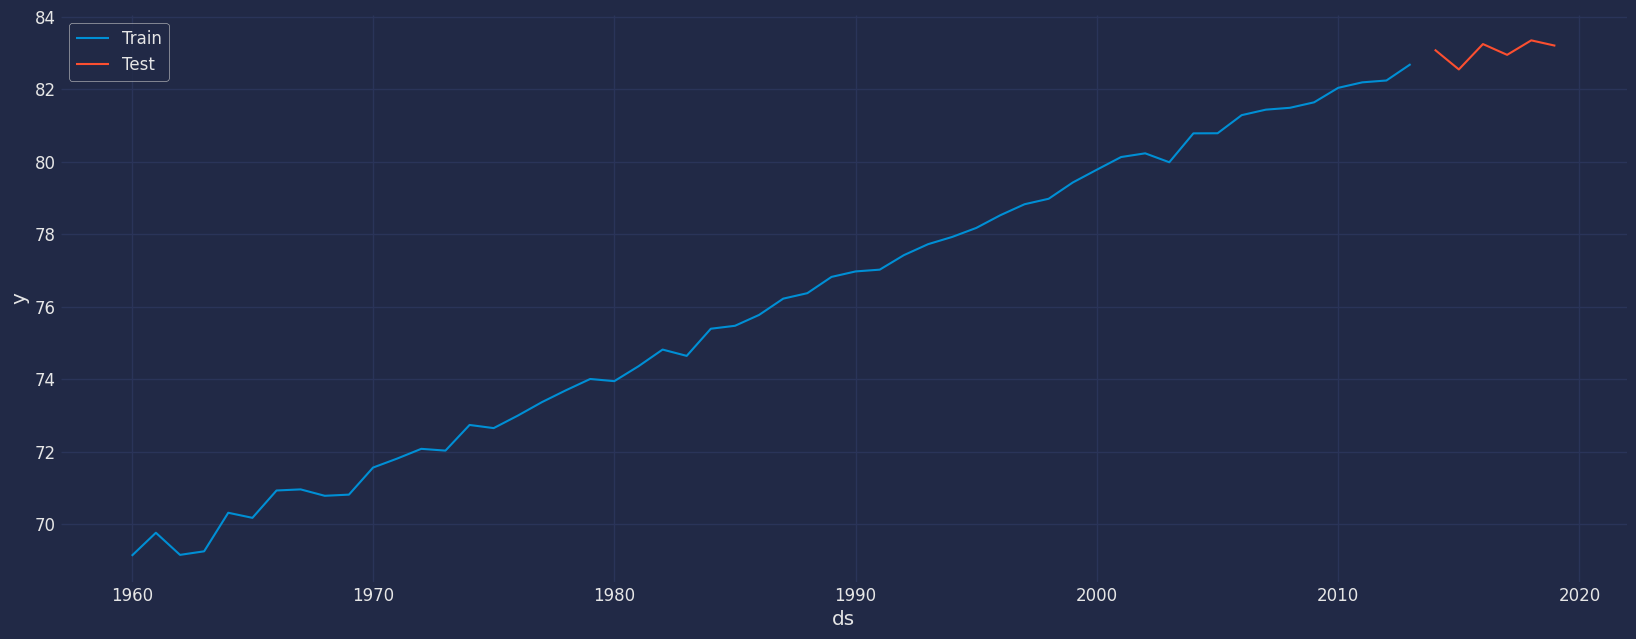

In [ ]:
sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.show()

## Implementation of AutoCES with StatsForecast <a class="anchor" id="implementation"></a>

### Load libraries

In [ ]:
from statsforecast import StatsForecast
from statsforecast.models import AutoCES

### Instantiate Model

Import and instantiate the models. Setting the argument is sometimes tricky. This article on [Seasonal periods](https://robjhyndman.com/hyndsight/seasonal-periods/)) by the master, Rob Hyndmann, can be useful `season_length`

**Note**

Automatically selects the best `Complex Exponential Smoothing model` using an information criterion. Default is Akaike Information Criterion (AICc), while particular models are estimated using maximum likelihood. The state-space equations can be determined based on their $S$ simple, $P$ parial, $Z$ optimized or $N$ ommited components. The model string parameter defines the kind of CES model: $N$ for simple CES (withous seasonality), $S$ for simple seasonality (lagged CES), $P$ for partial seasonality (without complex part), $F$ for full seasonality (lagged CES with real and complex seasonal parts).

If the component is selected as $Z$, it operates as a placeholder to ask the AutoCES model to figure out the best parameter.

In [ ]:
season_length = 1 # year data
horizon = len(test) # number of predictions

# We call the model that we are going to use
models = [AutoCES(season_length=season_length)]

We fit the models by instantiating a new StatsForecast object with the following parameters:

models: a list of models. Select the models you want from models and import them.

* `freq:` a string indicating the frequency of the data. (See [pandas’ available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).)

* `n_jobs:` n_jobs: int, number of jobs used in the parallel processing, use -1 for all cores.

* `fallback_model:` a model to be used if a model fails.

Any settings are passed into the constructor. Then you call its fit method and pass in the historical data frame.

In [ ]:
sf = StatsForecast(models=models, freq='YS')

### Fit the Model

In [ ]:
sf.fit(df=train)

StatsForecast(models=[CES])

In [ ]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['fit'])

dict_keys(['loglik', 'aic', 'bic', 'aicc', 'mse', 'amse', 'fit', 'fitted', 'residuals', 'm', 'states', 'par', 'n', 'seasontype', 'sigma2', 'actual_residuals'])
results(x=array([1.63706552, 1.00511519]), fn=76.78049826760919, nit=27, simplex=array([[1.63400329, 1.00510199],
       [1.63706552, 1.00511519],
       [1.63638944, 1.00512037]]))


Let us now visualize the residuals of our models.

As we can see, the result obtained above has an output in a dictionary, to extract each element from the dictionary we are going to use the `.get()` function to extract the element and then we are going to save it in a `pd.DataFrame()`.

In [ ]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,-0.727729
1,0.144552
2,-0.762086
...,...
51,-0.073258
52,-0.234578
53,0.109990


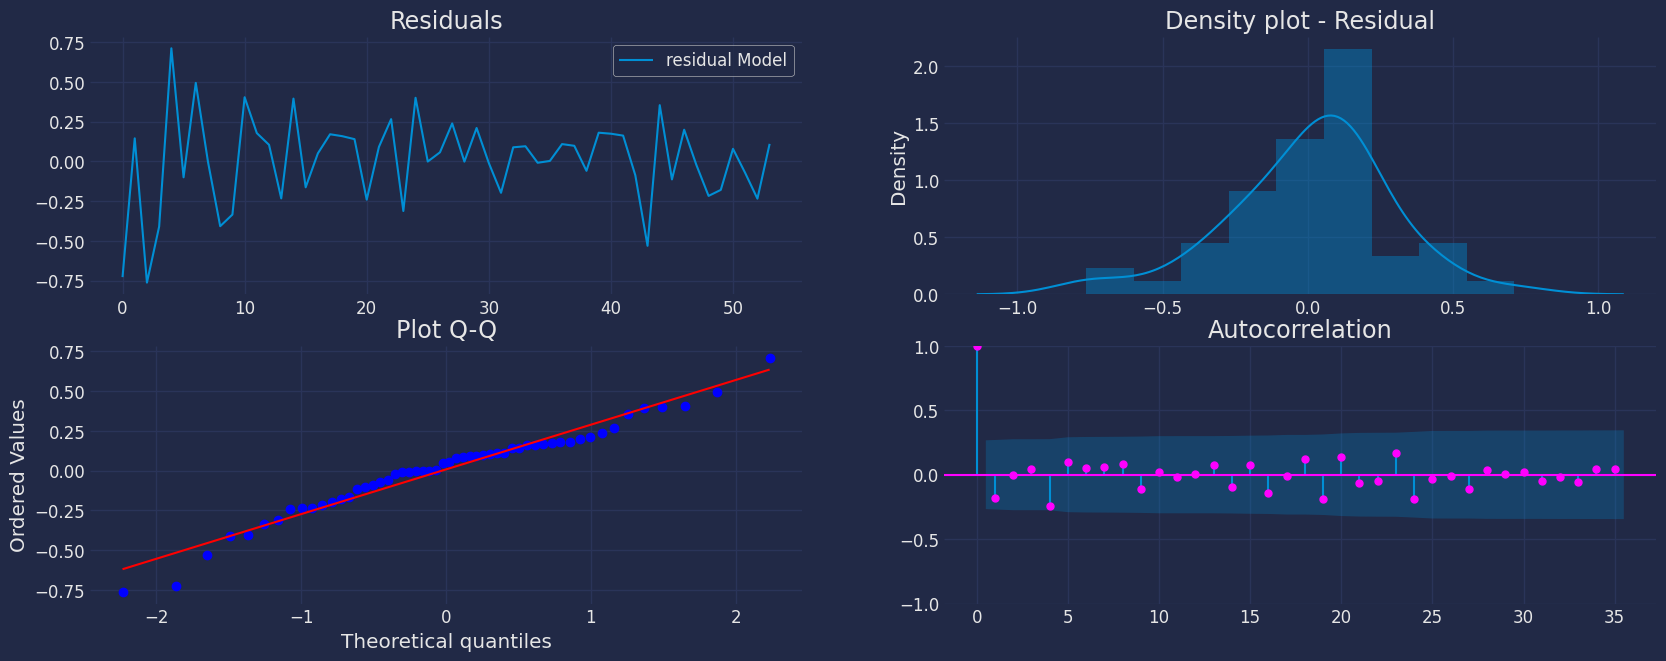

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

### Forecast Method

If you want to gain speed in productive settings where you have multiple series or models we recommend using the `StatsForecast.forecast` method instead of `.fit` and `.predict`.

The main difference is that the `.forecast` doest not store the fitted values and is highly scalable in distributed environments.

The forecast method takes two arguments: forecasts next `h` (horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[90]` means that the model expects the real value to be inside that interval 90% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals. Depending on your computer, this step should take around 1min. (If you want to speed things up to a couple of seconds, remove the AutoModels like `ARIMA` and `Theta`)

In [ ]:
# Prediction
Y_hat = sf.forecast(df=train, h=horizon, fitted=True)
Y_hat

,unique_id,ds,CES
0,1,2014-01-01,82.906075
1,1,2015-01-01,83.166687
2,1,2016-01-01,83.424744
3,1,2017-01-01,83.685760
4,1,2018-01-01,83.946213
5,1,2019-01-01,84.208359


In [ ]:
values=sf.forecast_fitted_values()
values.head()

,unique_id,ds,y,CES
0,1,1960-01-01,69.123902,69.851631
1,1,1961-01-01,69.760244,69.615692
2,1,1962-01-01,69.149756,69.911842
3,1,1963-01-01,69.248049,69.657822
4,1,1964-01-01,70.311707,69.601196


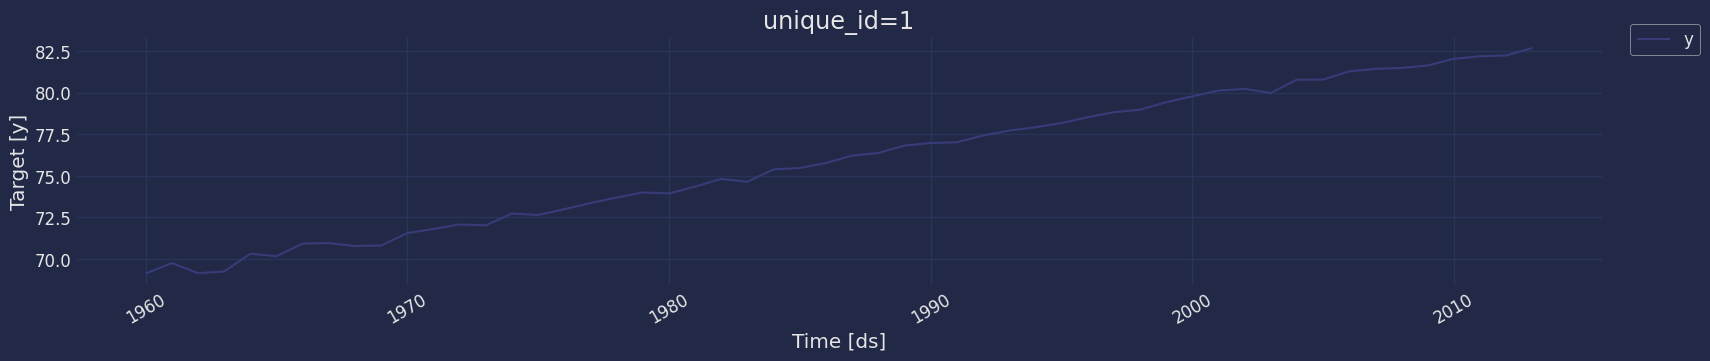

In [ ]:
StatsForecast.plot(values)

Adding 95% confidence interval with the forecast method

In [ ]:
sf.forecast(df=train, h=horizon, level=[95])

,unique_id,ds,CES,CES-lo-95,CES-hi-95
0,1,2014-01-01,82.906075,82.342483,83.454016
1,1,2015-01-01,83.166687,82.604029,83.717271
2,1,2016-01-01,83.424744,82.858573,83.975870
3,1,2017-01-01,83.685760,83.118946,84.239582
4,1,2018-01-01,83.946213,83.376905,84.501133
5,1,2019-01-01,84.208359,83.637738,84.765408


In [ ]:
# Merge the forecasts with the true values
Y_hat = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])
Y_hat

,ds,y,unique_id,CES
0,2014-01-01,83.090244,1,82.906075
1,2015-01-01,82.543902,1,83.166687
2,2016-01-01,83.243902,1,83.424744
3,2017-01-01,82.946341,1,83.685760
4,2018-01-01,83.346341,1,83.946213
5,2019-01-01,83.197561,1,84.208359


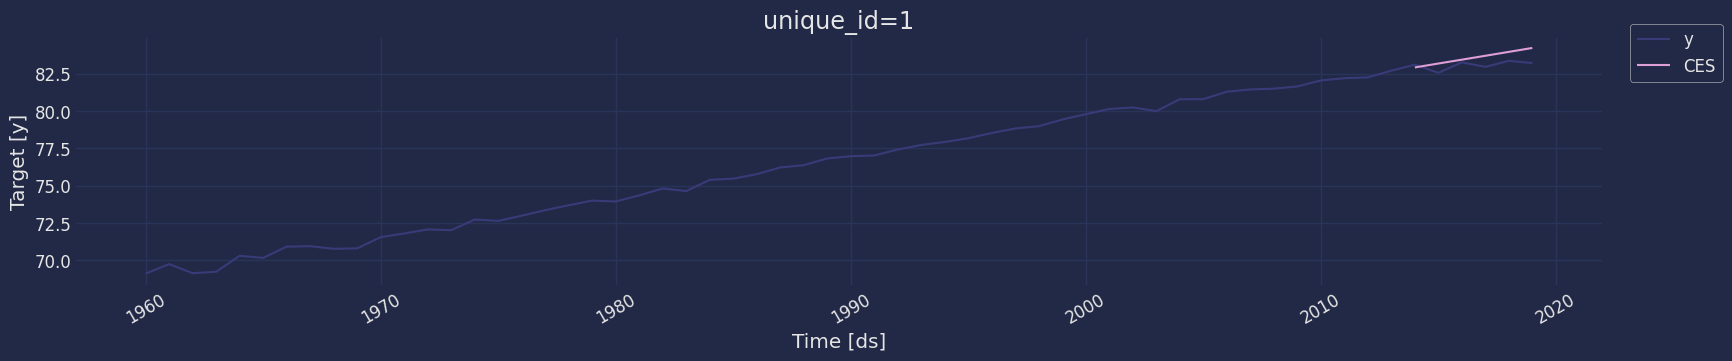

In [ ]:
sf.plot(train, Y_hat)

### Predict method with confidence interval

To generate forecasts use the predict method.

The predict method takes two arguments: forecasts the next `h` (for horizon) and `level`.

* `h (int):` represents the forecast h steps into the future. In this case, 12 months ahead.

* `level (list of floats):` this optional parameter is used for probabilistic forecasting. Set the level (or confidence percentile) of your prediction interval. For example, `level=[95]` means that the model expects the real value to be inside that interval 95% of the times.

The forecast object here is a new data frame that includes a column with the name of the model and the y hat values, as well as columns for the uncertainty intervals.

This step should take less than 1 second.

In [ ]:
sf.predict(h=horizon)

,unique_id,ds,CES
0,1,2014-01-01,82.906075
1,1,2015-01-01,83.166687
2,1,2016-01-01,83.424744
3,1,2017-01-01,83.685760
4,1,2018-01-01,83.946213
5,1,2019-01-01,84.208359


In [ ]:
forecast_df = sf.predict(h=horizon, level=[95])
forecast_df

,unique_id,ds,CES,CES-lo-95,CES-hi-95
0,1,2014-01-01,82.906075,82.342483,83.454016
1,1,2015-01-01,83.166687,82.604029,83.717271
2,1,2016-01-01,83.424744,82.858573,83.975870
3,1,2017-01-01,83.685760,83.118946,84.239582
4,1,2018-01-01,83.946213,83.376905,84.501133
5,1,2019-01-01,84.208359,83.637738,84.765408


Now let's visualize the result of our forecast and the historical data of our time series, also let's draw the confidence interval that we have obtained when making the prediction with 95% confidence.

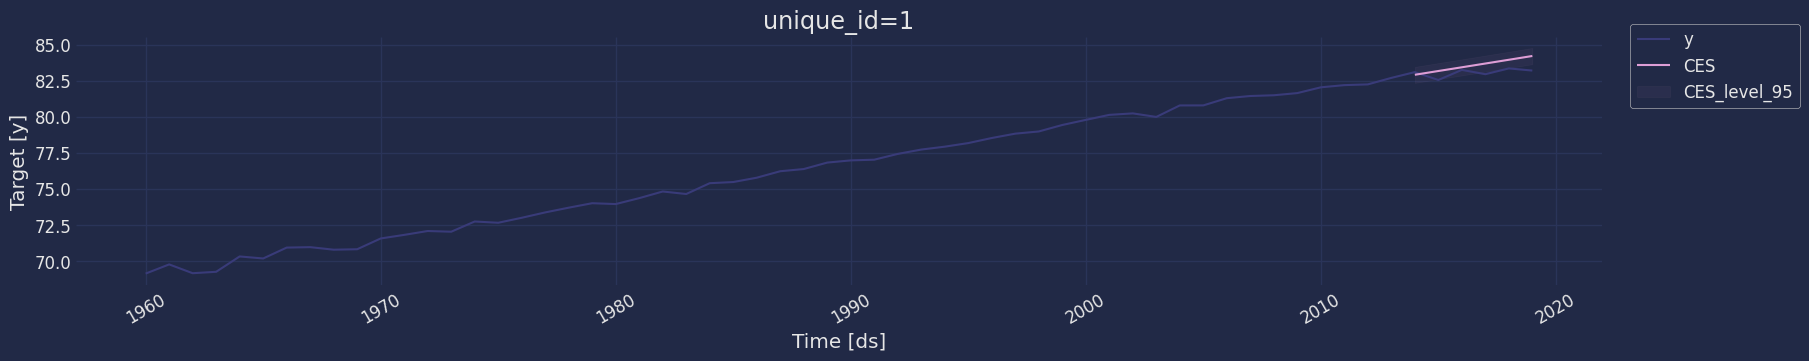

In [ ]:
sf.plot(train, test.merge(forecast_df), level=[95])

## Cross-validation <a class="anchor" id="cross_validate"></a>

In previous steps, we’ve taken our historical data to predict the future. However, to asses its accuracy we would also like to know how the model would have performed in the past. To assess the accuracy and robustness of your models on your data perform Cross-Validation.

With time series data, Cross Validation is done by defining a sliding window across the historical data and predicting the period following it. This form of cross-validation allows us to arrive at a better estimation of our model’s predictive abilities across a wider range of temporal instances while also keeping the data in the training set contiguous as is required by our models.

The following graph depicts such a Cross Validation Strategy:

![](https://raw.githubusercontent.com/Nixtla/statsforecast/main/nbs/imgs/ChainedWindows.gif)

### Perform time series cross-validation

Cross-validation of time series models is considered a best practice but most implementations are very slow. The statsforecast library implements cross-validation as a distributed operation, making the process less time-consuming to perform. If you have big datasets you can also perform Cross Validation in a distributed cluster using Ray, Dask or Spark.

In this case, we want to evaluate the performance of each model for the last 5 months `(n_windows=5)`, forecasting every second months `(step_size=12)`. Depending on your computer, this step should take around 1 min.

The cross_validation method from the StatsForecast class takes the following arguments.

* `df:` training data frame

* `h (int):` represents h steps into the future that are being forecasted. In this case, 12 months ahead.

* `step_size (int):` step size between each window. In other words: how often do you want to run the forecasting processes.

* `n_windows(int):` number of windows used for cross validation. In other words: what number of forecasting processes in the past do you want to evaluate.

In [ ]:
crossvalidation_df = sf.cross_validation(df=train,
                                         h=horizon,
                                         step_size=12,
                                         n_windows=3)

The crossvaldation_df object is a new data frame that includes the following columns:

*  `unique_id:` series identifier
* `ds:` datestamp or temporal index
* `cutoff:` the last datestamp or temporal index for the n_windows.
* `y:` true value
* `"model":` columns with the model’s name and fitted value.

In [ ]:
crossvalidation_df.head()

,unique_id,ds,cutoff,y,CES
0,1,1984-01-01,1983-01-01,75.389512,74.952705
1,1,1985-01-01,1983-01-01,75.470732,75.161736
2,1,1986-01-01,1983-01-01,75.770732,75.377945
3,1,1987-01-01,1983-01-01,76.219512,75.590378
4,1,1988-01-01,1983-01-01,76.370732,75.806343


## Model Evaluation <a class="anchor" id="evaluate"></a>

Now we are going to evaluate our model with the results of the predictions, we will use different types of metrics MAE, MAPE, MASE, RMSE, SMAPE to evaluate the accuracy.

In [ ]:
from functools import partial

import utilsforecast.losses as ufl
from utilsforecast.evaluation import evaluate

In [ ]:
evaluate(
    Y_hat,
    metrics=[ufl.mae, ufl.mape, partial(ufl.mase, seasonality=season_length), ufl.rmse, ufl.smape],
    train_df=train,
)

,unique_id,metric,CES
0,1,mae,0.556314
1,1,mape,0.006699
2,1,mase,1.770512
3,1,rmse,0.630183
4,1,smape,0.003336


## References <a class="anchor" id="references"></a>

1. [Nixtla AutoCES API](../../models#class-autoces)
2. [Rob J. Hyndman and George Athanasopoulos (2018). “Forecasting Principles and Practice (3rd ed)”](https://otexts.com/fpp3/tscv.html).
3. [Ivan Svetunkov, Nikolaos Kourentzes, John Keith Ord, "Complex exponential smoothing"](https://onlinelibrary.wiley.com/doi/full/10.1002/nav.22074)